In [1]:
# Run this cell to mount your Google Drive.

from IPython.display import clear_output, Image
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [2]:
# !pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

clear_output()

In [3]:
import torch
import numpy as np
import tensorflow
import os
import importlib

# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from MLP import *
from models import *

# remove pycache
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/agents/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/envs/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/games/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/utils/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/
%rm -r __pycache__

%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn

try:
    importlib.reload(rlcard)
    importlib.reload(rlcard.utils)
    importlib.reload(rlcard.agents.random_agent)
    importlib.reload(rlcard.agents.dqn_agent_pytorch)
    importlib.reload(rlcard.agents.simpleGinRummy_agent)
    importlib.reload(rlcard.games.gin_rummy.utils.scorers)
except:
    pass

import rlcard
from rlcard.utils import set_global_seed, tournament, tournament2, tournament3
from rlcard.utils import Logger
from rlcard.agents.random_agent import RandomAgent
from rlcard.agents.dqn_agent_pytorch import DQNAgent
from rlcard.agents.simpleGinRummy_agent import SimpleGinRummyAgent

# different versions of payoff functions
from rlcard.games.gin_rummy.utils.scorers import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

clear_output()

# Knock Layer Testing

## Artificially increased Knock Probabilities (0.2)

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'knock_point2'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# freeze_layers, copy top layer weights
freeze_layers = True
copy_top = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 0.2

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/knockLayer/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=mlp_layers,
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm,
                knock_layer=knock_layer)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=mlp_layers,
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm,
                  knock_layer=knock_layer)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

# load DQN pretrained weights using built in load function
if isDQN:
    agent.load(checkpoint)
    agent2.load(checkpoint)
else:
    model_dict = checkpoint.state_dict()
    # Generate pretrained dictionary of weights/biases
    pretrained_dict = {}

    # check if there is batch norm layer
    if batch_norm:
        b_layer = 1 
        pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
        pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
        pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
        pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
        pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
    else:
        b_layer = 0

    for i in range(len(mlp_layers)):
        pretrained_dict['fc_layers.{}.weight'.format(2*i+1+b_layer)] = model_dict['l{}.weight'.format(i+1)]
        pretrained_dict['fc_layers.{}.bias'.format(2*i+1+b_layer)] = model_dict['l{}.bias'.format(i+1)]
    
    # check if copy top layer weights
    if copy_top:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.eye(110), device=device)
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.ones(110), device=device)
    else:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].weight
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].bias
    
    # check if extra layer for knocking
    if knock_layer:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(np.eye(110), device=device)
        knock_probs = np.ones(110)*knock_val
        knock_probs[0:58] = 0
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(knock_probs, device=device)
    
    # load pretrained weights
    agent.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent.target_estimator.qnet.load_state_dict(pretrained_dict)

    agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# check if freeze layers (DO NOT FREEZE TOP LAYER)
if freeze_layers:
    for i in range(len(mlp_layers)):
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
    # check if extra layer for knocking
    if knock_layer:
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

### Train

#### Training Loop

Streaming output truncated to the last 5000 lines.

SGRAgent:

----------------------------------------
  timestep     |  517220
  reward       |  -0.23810000000000006
  Avg Turns    |  18.91
  Cond_Knock   |  1.0
  Gin: 1 | Knock: 22 | Other: 77
----------------------------------------
INFO - Agent dqn, step 264500, rl-loss: 0.006169244647026062
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  528879
  reward       |  0.21399999999999963
  Avg Turns    |  32.51
  Cond_Knock   |  1.0
  Gin: 2 | Knock: 96 | Other: 2
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  528879
  reward       |  -0.024299999999999978
  Avg Turns    |  21.38
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 42 | Other: 58
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  528879
  reward       |  -0.1660000000

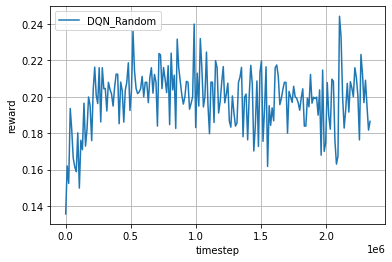

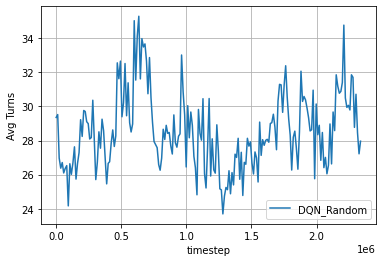

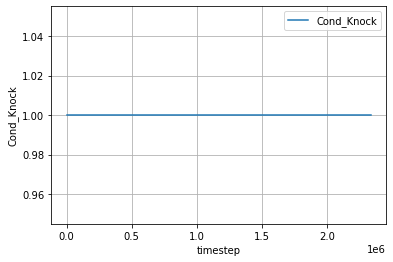

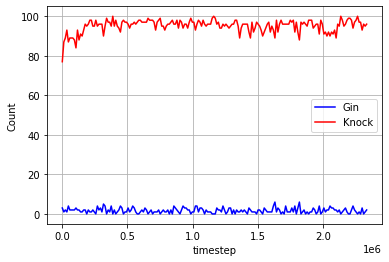

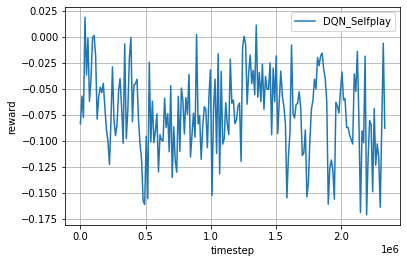

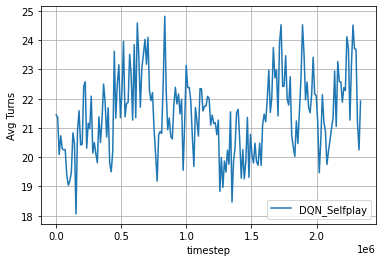

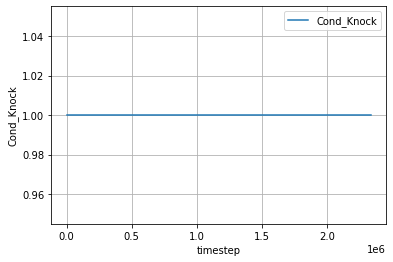

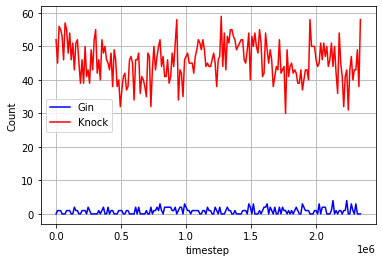

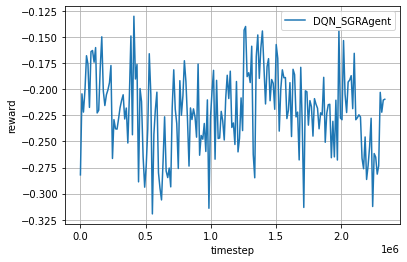

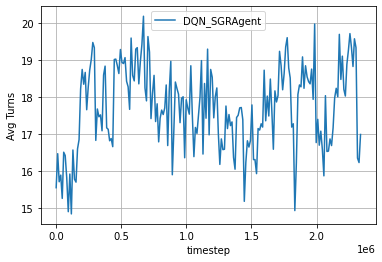

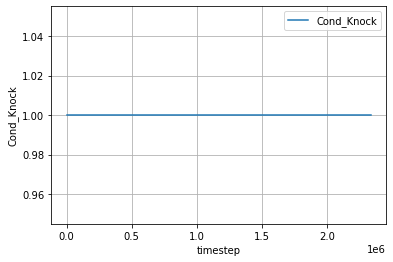

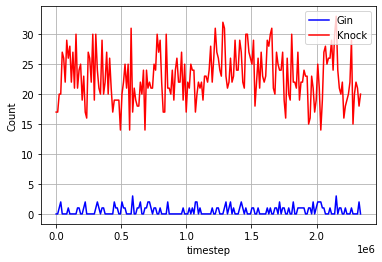

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/knockLayer/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        reward_rand = tournament(random_env, evaluate_num)[0]
        actions_rand = tournament2(random_env, evaluate_num)
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        reward_self = tournament(selfplay_env, evaluate_num)[0]
        actions_self = tournament2(selfplay_env, evaluate_num)
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        reward_sgr = tournament(SGRAgent_env, evaluate_num)[0]
        actions_sgr = tournament2(SGRAgent_env, evaluate_num)
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [ ]:
model_name = 'models/dqn/knockLayer/{}/model_posttrain.pth'.format(dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

###### Random

In [ ]:
actions = tournament2(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 93, 'Other': 6, 'Knock_Possible': 93, 'Avg Turns': 27.72}


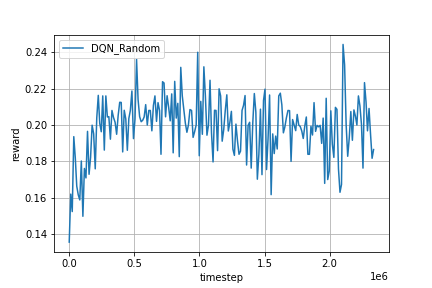

In [ ]:
Image(log_dir + '/rand_fig.png')

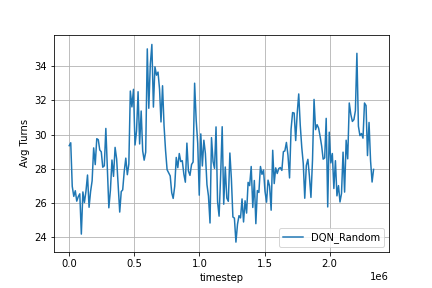

In [ ]:
Image(log_dir + '/rand_fig2.png')

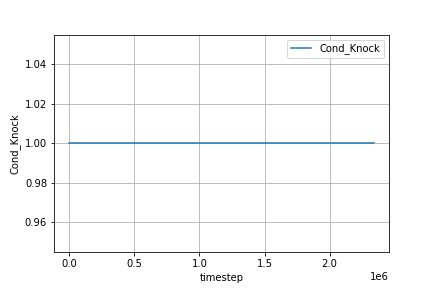

In [ ]:
Image(log_dir + '/rand_fig3.png')

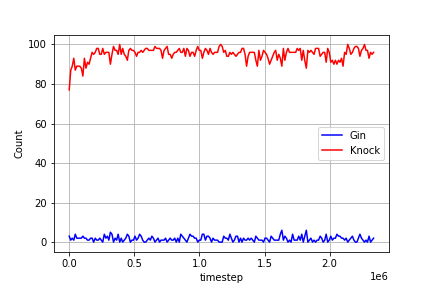

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
actions = tournament2(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 47, 'Other': 52, 'Knock_Possible': 47, 'Avg Turns': 23.71}


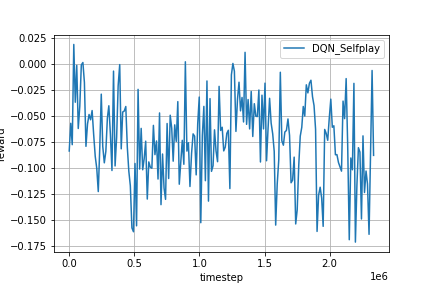

In [ ]:
Image(log_dir + '/self_fig.png')

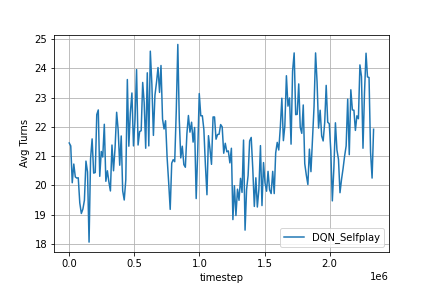

In [ ]:
Image(log_dir + '/self_fig2.png')

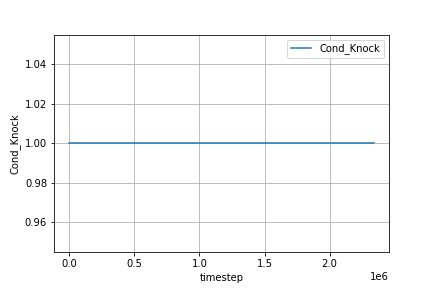

In [ ]:
Image(log_dir + '/self_fig3.png')

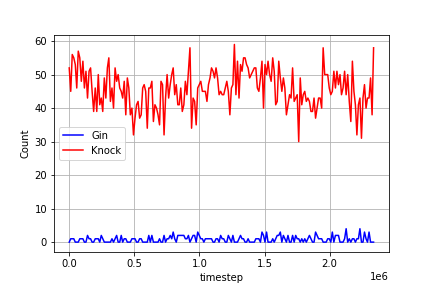

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
actions = tournament2(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 24, 'Other': 76, 'Knock_Possible': 24, 'Avg Turns': 17.29}


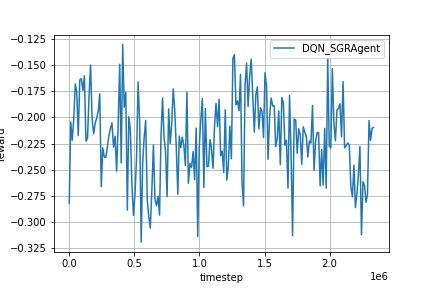

In [ ]:
Image(log_dir + '/sgr_fig.png')

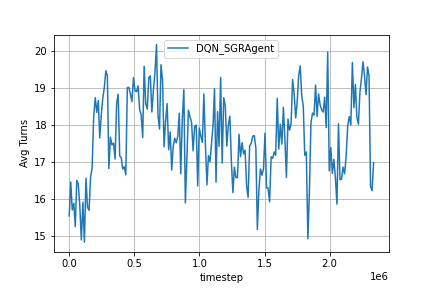

In [ ]:
Image(log_dir + '/sgr_fig2.png')

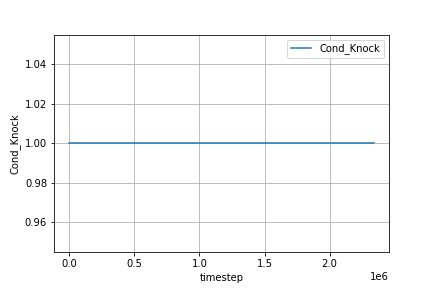

In [ ]:
Image(log_dir + '/sgr_fig3.png')

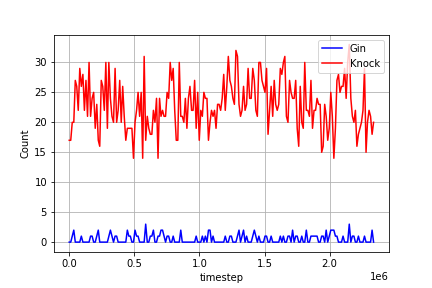

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## Artificially increased Knock Probabilities (0.2) TEST same agent

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'knock_point2_test'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# freeze_layers, copy top layer weights
freeze_layers = True
copy_top = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 0.2

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/knockLayer/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=mlp_layers,
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm,
                knock_layer=knock_layer)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=mlp_layers,
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm,
                  knock_layer=knock_layer)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

# load DQN pretrained weights using built in load function
if isDQN:
    agent.load(checkpoint)
    agent2.load(checkpoint)
else:
    model_dict = checkpoint.state_dict()
    # Generate pretrained dictionary of weights/biases
    pretrained_dict = {}

    # check if there is batch norm layer
    if batch_norm:
        b_layer = 1 
        pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
        pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
        pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
        pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
        pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
    else:
        b_layer = 0

    for i in range(len(mlp_layers)):
        pretrained_dict['fc_layers.{}.weight'.format(2*i+1+b_layer)] = model_dict['l{}.weight'.format(i+1)]
        pretrained_dict['fc_layers.{}.bias'.format(2*i+1+b_layer)] = model_dict['l{}.bias'.format(i+1)]
    
    # check if copy top layer weights
    if copy_top:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.eye(110), device=device)
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.ones(110), device=device)
    else:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].weight
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].bias
    
    # check if extra layer for knocking
    if knock_layer:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(np.eye(110), device=device)
        knock_probs = np.ones(110)*knock_val
        knock_probs[0:58] = 0
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(knock_probs, device=device)
    
    # load pretrained weights
    agent.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent.target_estimator.qnet.load_state_dict(pretrained_dict)

    agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# check if freeze layers (DO NOT FREEZE TOP LAYER)
if freeze_layers:
    for i in range(len(mlp_layers)):
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
    # check if extra layer for knocking
    if knock_layer:
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/knockLayer/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [ ]:
model_name = 'models/dqn/knockLayer/{}/model_posttrain.pth'.format(dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 87, 'Other': 11, 'Knock_Possible': 87, 'Avg Turns': 28.53}


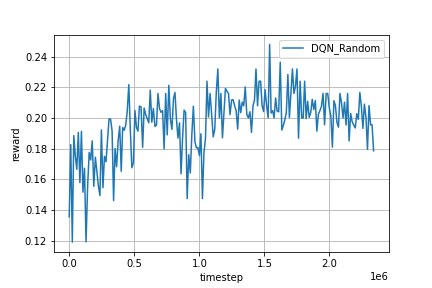

In [ ]:
Image(log_dir + '/rand_fig.png')

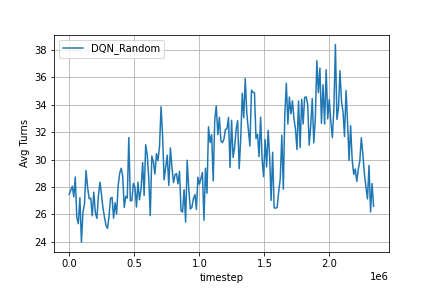

In [ ]:
Image(log_dir + '/rand_fig2.png')

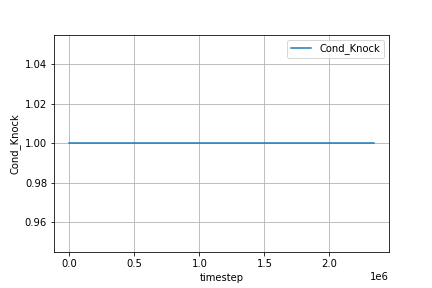

In [ ]:
Image(log_dir + '/rand_fig3.png')

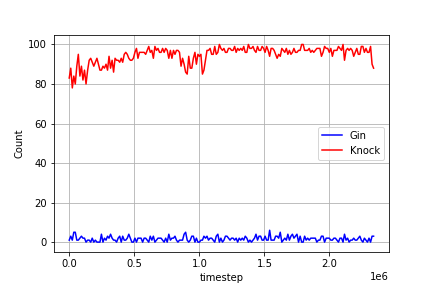

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 50, 'Other': 49, 'Knock_Possible': 50, 'Avg Turns': 22.66}


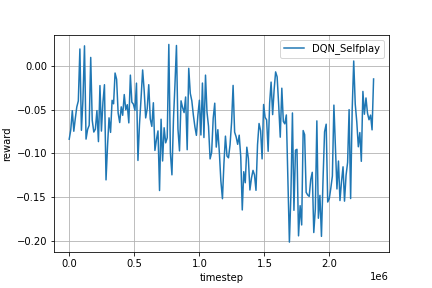

In [ ]:
Image(log_dir + '/self_fig.png')

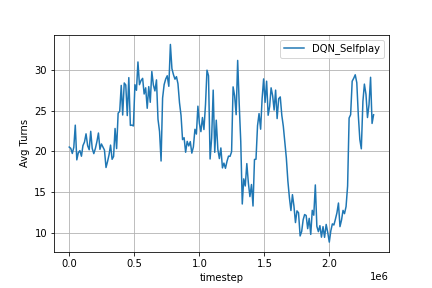

In [ ]:
Image(log_dir + '/self_fig2.png')

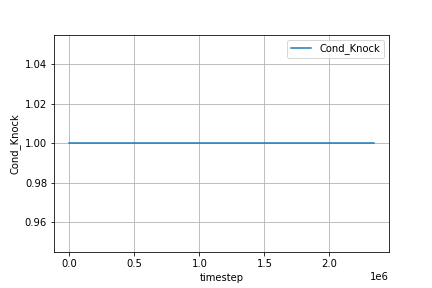

In [ ]:
Image(log_dir + '/self_fig3.png')

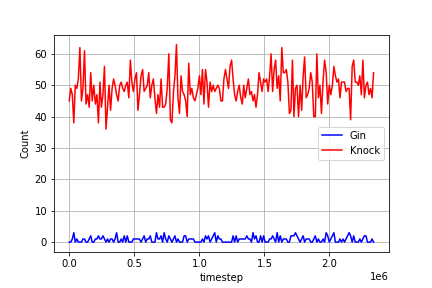

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 15, 'Other': 85, 'Knock_Possible': 15, 'Avg Turns': 17.63}


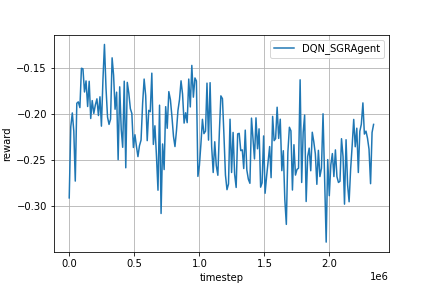

In [ ]:
Image(log_dir + '/sgr_fig.png')

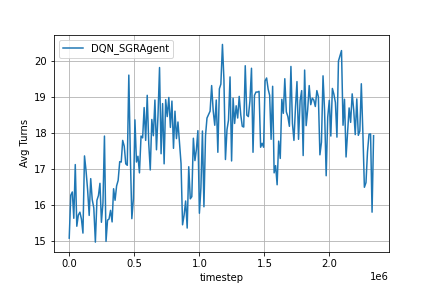

In [ ]:
Image(log_dir + '/sgr_fig2.png')

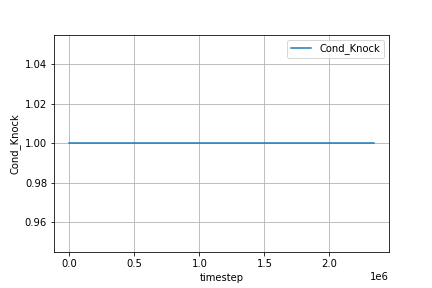

In [ ]:
Image(log_dir + '/sgr_fig3.png')

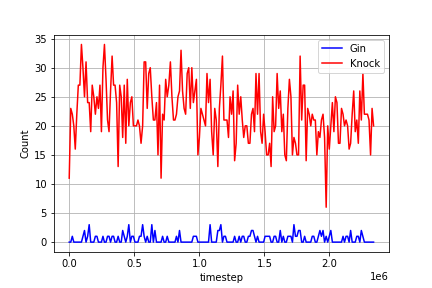

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## Artificially increased Knock Probabilities (0.02)

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'knock_point02'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# freeze_layers, copy top layer weights
freeze_layers = True
copy_top = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 0.02

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/knockLayer/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=mlp_layers,
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm,
                knock_layer=knock_layer)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=mlp_layers,
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm,
                  knock_layer=knock_layer)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

# load DQN pretrained weights using built in load function
if isDQN:
    agent.load(checkpoint)
    agent2.load(checkpoint)
else:
    model_dict = checkpoint.state_dict()
    # Generate pretrained dictionary of weights/biases
    pretrained_dict = {}

    # check if there is batch norm layer
    if batch_norm:
        b_layer = 1 
        pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
        pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
        pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
        pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
        pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
    else:
        b_layer = 0

    for i in range(len(mlp_layers)):
        pretrained_dict['fc_layers.{}.weight'.format(2*i+1+b_layer)] = model_dict['l{}.weight'.format(i+1)]
        pretrained_dict['fc_layers.{}.bias'.format(2*i+1+b_layer)] = model_dict['l{}.bias'.format(i+1)]
    
    # check if copy top layer weights
    if copy_top:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.eye(110), device=device)
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.ones(110), device=device)
    else:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].weight
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].bias
    
    # check if extra layer for knocking
    if knock_layer:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(np.eye(110), device=device)
        knock_probs = np.ones(110)*knock_val
        knock_probs[0:58] = 0
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(knock_probs, device=device)
    
    # load pretrained weights
    agent.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent.target_estimator.qnet.load_state_dict(pretrained_dict)

    agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# check if freeze layers (DO NOT FREEZE TOP LAYER)
if freeze_layers:
    for i in range(len(mlp_layers)):
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
    # check if extra layer for knocking
    if knock_layer:
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

### Train

#### Training Loop

Streaming output truncated to the last 5000 lines.

SGRAgent:

----------------------------------------
  timestep     |  517682
  reward       |  -0.29330000000000006
  Avg Turns    |  16.07
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 14 | Other: 86
----------------------------------------
INFO - Agent dqn, step 264800, rl-loss: 0.008204377256333828
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  529466
  reward       |  0.08889999999999999
  Avg Turns    |  31.57
  Cond_Knock   |  1.0
  Gin: 2 | Knock: 71 | Other: 27
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  529466
  reward       |  -0.059899999999999905
  Avg Turns    |  23.96
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 51 | Other: 49
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  529466
  reward       |  -0.263500000

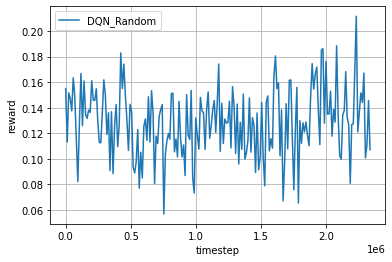

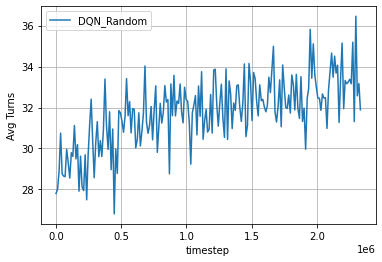

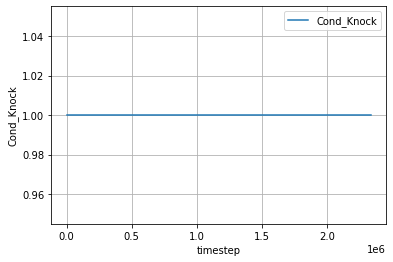

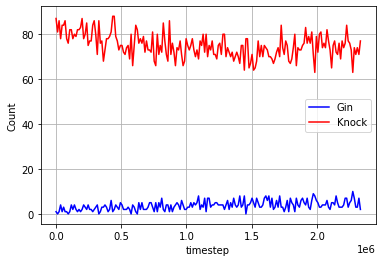

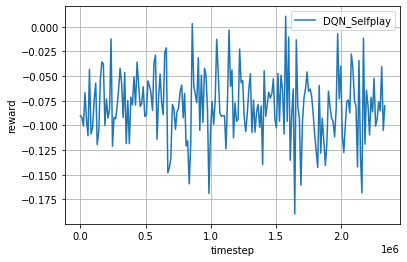

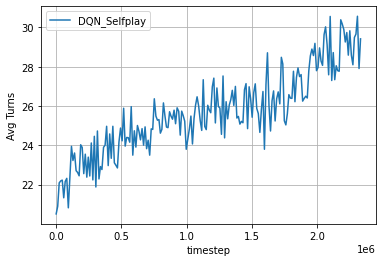

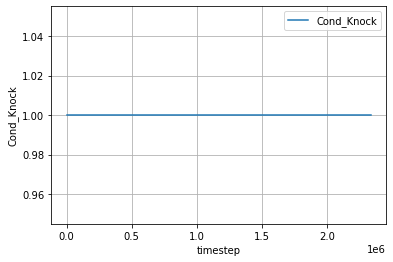

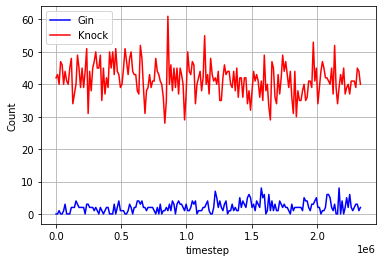

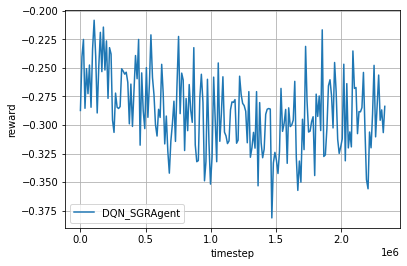

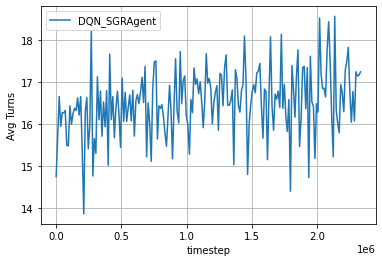

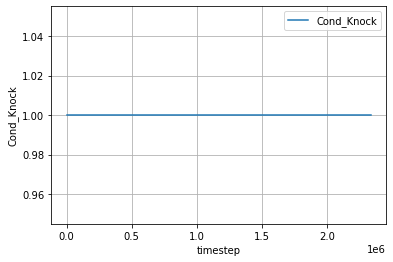

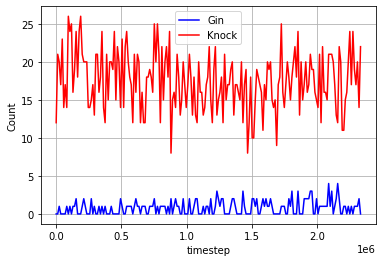

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/knockLayer/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [ ]:
model_name = 'models/dqn/knockLayer/{}/model_posttrain.pth'.format(dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 4, 'Knock': 79, 'Other': 17, 'Knock_Possible': 79, 'Avg Turns': 33.68}


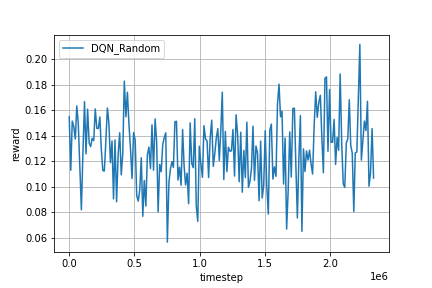

In [ ]:
Image(log_dir + '/rand_fig.png')

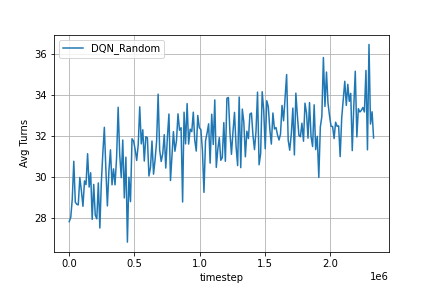

In [ ]:
Image(log_dir + '/rand_fig2.png')

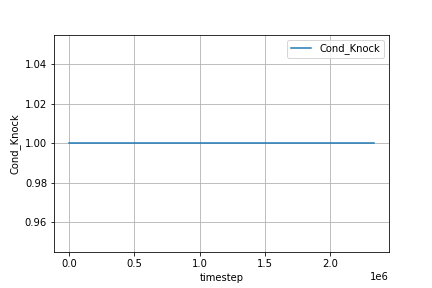

In [ ]:
Image(log_dir + '/rand_fig3.png')

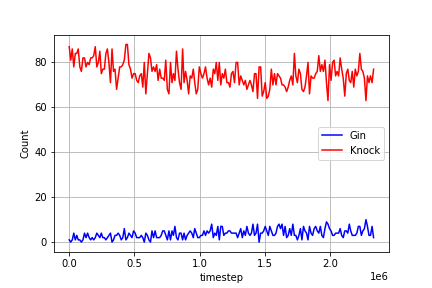

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 4, 'Knock': 40, 'Other': 56, 'Knock_Possible': 40, 'Avg Turns': 28.79}


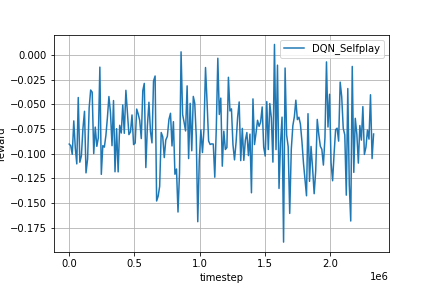

In [ ]:
Image(log_dir + '/self_fig.png')

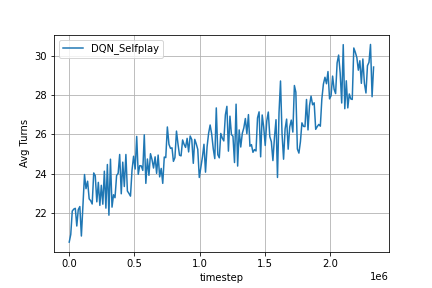

In [ ]:
Image(log_dir + '/self_fig2.png')

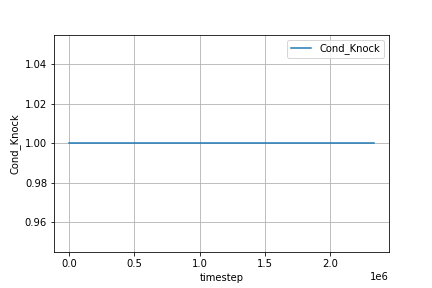

In [ ]:
Image(log_dir + '/self_fig3.png')

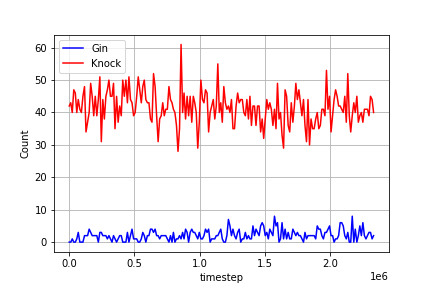

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 16, 'Other': 83, 'Knock_Possible': 16, 'Avg Turns': 17.99}


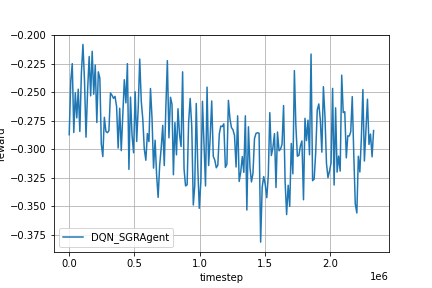

In [ ]:
Image(log_dir + '/sgr_fig.png')

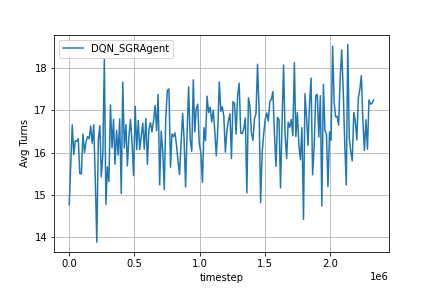

In [ ]:
Image(log_dir + '/sgr_fig2.png')

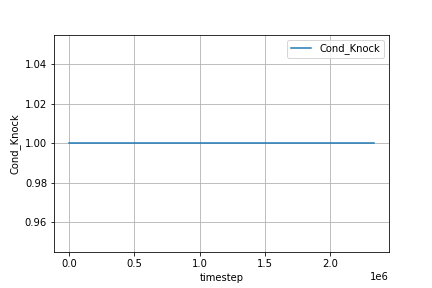

In [ ]:
Image(log_dir + '/sgr_fig3.png')

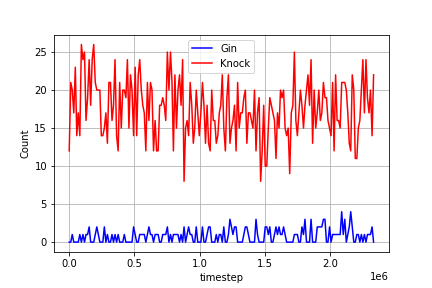

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## Artificially increased Knock Probabilities (0.002)

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'knock_point002'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# freeze_layers, copy top layer weights
freeze_layers = True
copy_top = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 0.002

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/knockLayer/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=mlp_layers,
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm,
                knock_layer=knock_layer)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=mlp_layers,
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm,
                  knock_layer=knock_layer)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

# load DQN pretrained weights using built in load function
if isDQN:
    agent.load(checkpoint)
    agent2.load(checkpoint)
else:
    model_dict = checkpoint.state_dict()
    # Generate pretrained dictionary of weights/biases
    pretrained_dict = {}

    # check if there is batch norm layer
    if batch_norm:
        b_layer = 1 
        pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
        pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
        pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
        pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
        pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
    else:
        b_layer = 0

    for i in range(len(mlp_layers)):
        pretrained_dict['fc_layers.{}.weight'.format(2*i+1+b_layer)] = model_dict['l{}.weight'.format(i+1)]
        pretrained_dict['fc_layers.{}.bias'.format(2*i+1+b_layer)] = model_dict['l{}.bias'.format(i+1)]
    
    # check if copy top layer weights
    if copy_top:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.eye(110), device=device)
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.ones(110), device=device)
    else:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].weight
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].bias
    
    # check if extra layer for knocking
    if knock_layer:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(np.eye(110), device=device)
        knock_probs = np.ones(110)*knock_val
        knock_probs[0:58] = 0
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(knock_probs, device=device)
    
    # load pretrained weights
    agent.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent.target_estimator.qnet.load_state_dict(pretrained_dict)

    agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# check if freeze layers (DO NOT FREEZE TOP LAYER)
if freeze_layers:
    for i in range(len(mlp_layers)):
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
    # check if extra layer for knocking
    if knock_layer:
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

### Train

#### Training Loop

Streaming output truncated to the last 5000 lines.

SGRAgent:

----------------------------------------
  timestep     |  490020
  reward       |  -0.26760000000000006
  Avg Turns    |  16.9
  Cond_Knock   |  0.9473684210526315
  Gin: 0 | Knock: 18 | Other: 82
----------------------------------------
INFO - Agent dqn, step 250900, rl-loss: 0.003151001175865531
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  501161
  reward       |  0.15209999999999974
  Avg Turns    |  33.86
  Cond_Knock   |  0.8260869565217391
  Gin: 5 | Knock: 76 | Other: 19
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  501161
  reward       |  -0.0069999999999999975
  Avg Turns    |  27.54
  Cond_Knock   |  0.8709677419354839
  Gin: 3 | Knock: 54 | Other: 43
----------------------------------------

SGRAgent:

----------------------------------------
  timestep

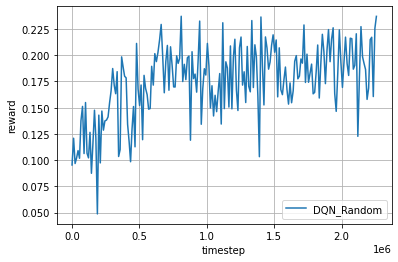

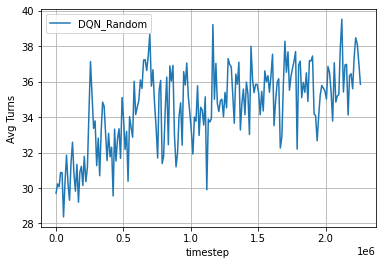

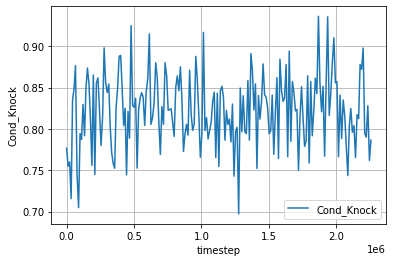

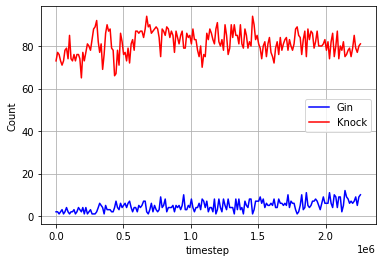

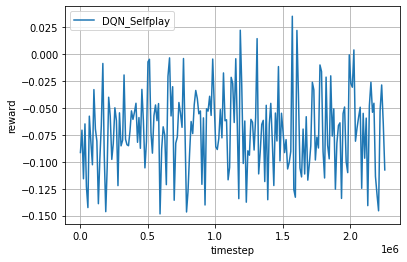

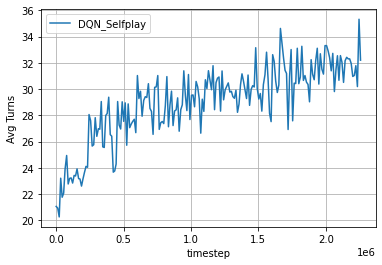

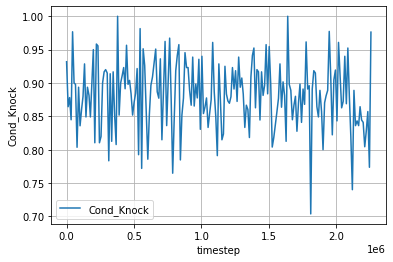

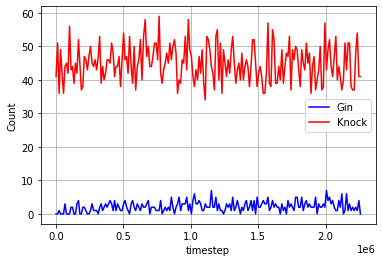

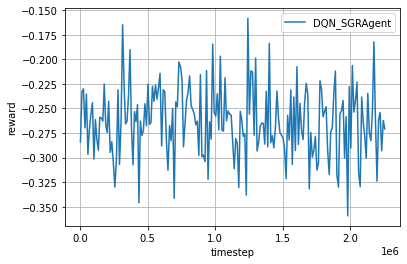

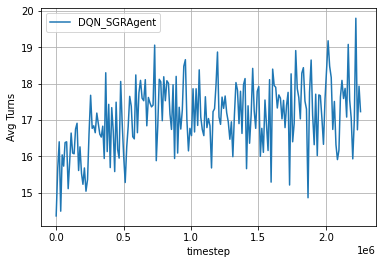

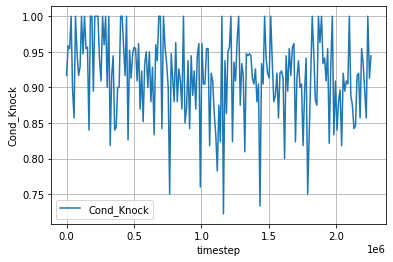

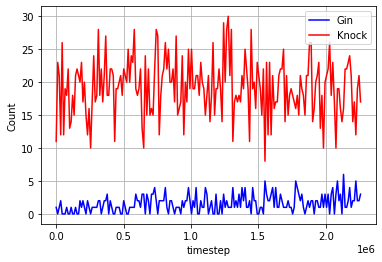

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/knockLayer/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [ ]:
model_name = 'models/dqn/knockLayer/{}/model_posttrain.pth'.format(dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 6, 'Knock': 82, 'Other': 12, 'Knock_Possible': 108, 'Avg Turns': 37.51}


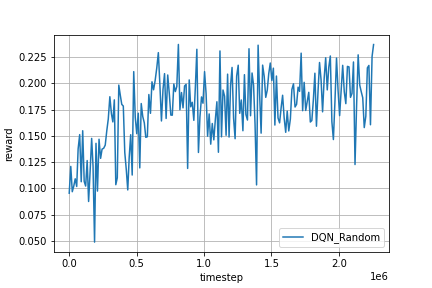

In [ ]:
Image(log_dir + '/rand_fig.png')

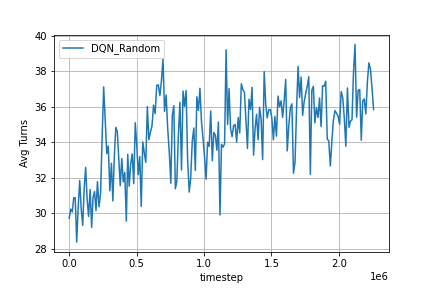

In [ ]:
Image(log_dir + '/rand_fig2.png')

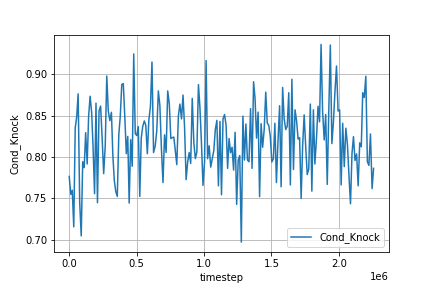

In [ ]:
Image(log_dir + '/rand_fig3.png')

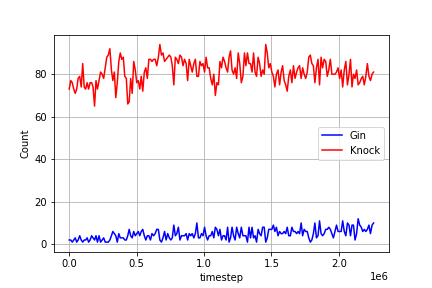

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 48, 'Other': 51, 'Knock_Possible': 54, 'Avg Turns': 32.29}


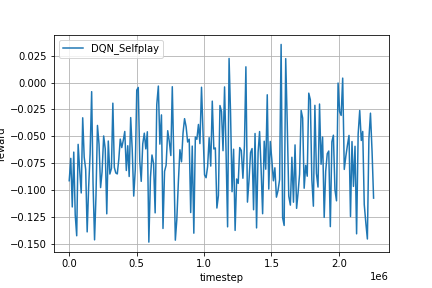

In [ ]:
Image(log_dir + '/self_fig.png')

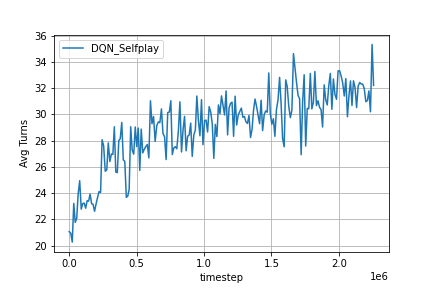

In [ ]:
Image(log_dir + '/self_fig2.png')

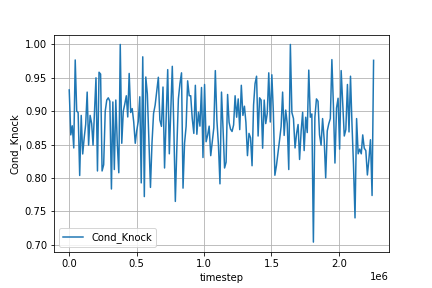

In [ ]:
Image(log_dir + '/self_fig3.png')

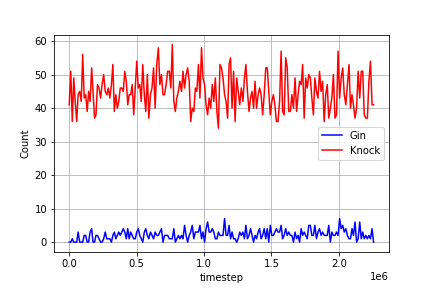

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 19, 'Other': 81, 'Knock_Possible': 23, 'Avg Turns': 18.09}


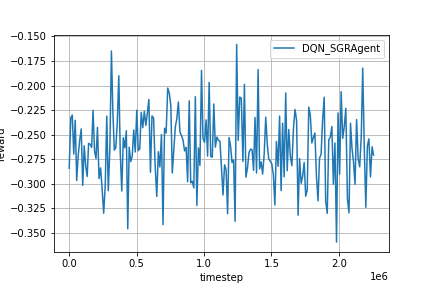

In [ ]:
Image(log_dir + '/sgr_fig.png')

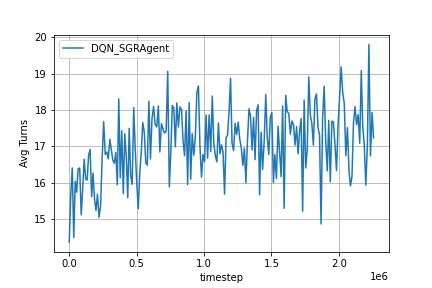

In [ ]:
Image(log_dir + '/sgr_fig2.png')

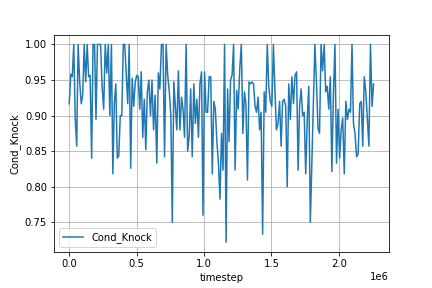

In [ ]:
Image(log_dir + '/sgr_fig3.png')

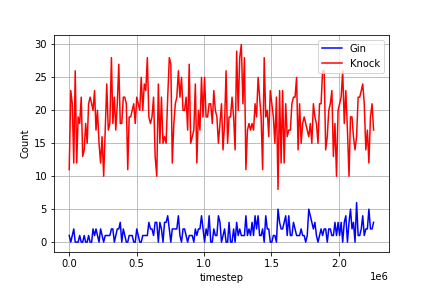

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## Artificially increased Knock Probabilities (0.002), selfplay

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'knock_point002_self'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# freeze_layers, copy top layer weights
freeze_layers = True
copy_top = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 0.002

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/knockLayer/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=mlp_layers,
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm,
                knock_layer=knock_layer)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=mlp_layers,
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm,
                  knock_layer=knock_layer)

# Training env
env.set_agents([agent, agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

# load DQN pretrained weights using built in load function
if isDQN:
    agent.load(checkpoint)
    agent2.load(checkpoint)
else:
    model_dict = checkpoint.state_dict()
    # Generate pretrained dictionary of weights/biases
    pretrained_dict = {}

    # check if there is batch norm layer
    if batch_norm:
        b_layer = 1 
        pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
        pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
        pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
        pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
        pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
    else:
        b_layer = 0

    for i in range(len(mlp_layers)):
        pretrained_dict['fc_layers.{}.weight'.format(2*i+1+b_layer)] = model_dict['l{}.weight'.format(i+1)]
        pretrained_dict['fc_layers.{}.bias'.format(2*i+1+b_layer)] = model_dict['l{}.bias'.format(i+1)]
    
    # check if copy top layer weights
    if copy_top:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.eye(110), device=device)
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.ones(110), device=device)
    else:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].weight
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].bias
    
    # check if extra layer for knocking
    if knock_layer:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(np.eye(110), device=device)
        knock_probs = np.ones(110)*knock_val
        knock_probs[0:58] = 0
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(knock_probs, device=device)
    
    # load pretrained weights
    agent.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent.target_estimator.qnet.load_state_dict(pretrained_dict)

    agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# check if freeze layers (DO NOT FREEZE TOP LAYER)
if freeze_layers:
    for i in range(len(mlp_layers)):
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
    # check if extra layer for knocking
    if knock_layer:
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent2.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

### Train

#### Training Loop

Streaming output truncated to the last 5000 lines.
  Gin: 1 | Knock: 39 | Other: 60
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  469349
  reward       |  -0.24100000000000005
  Avg Turns    |  16.03
  Cond_Knock   |  0.8695652173913043
  Gin: 2 | Knock: 20 | Other: 78
----------------------------------------
INFO - Agent dqn, step 236200, rl-loss: 0.0005696117295883596
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  479868
  reward       |  0.11959999999999994
  Avg Turns    |  32.72
  Cond_Knock   |  0.7047619047619048
  Gin: 3 | Knock: 74 | Other: 23
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  479868
  reward       |  -0.04179999999999996
  Avg Turns    |  26.66
  Cond_Knock   |  0.975
  Gin: 5 | Knock: 39 | Other: 56
----------------------------------------

S

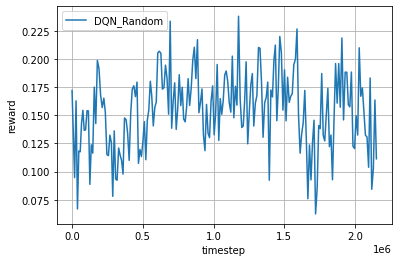

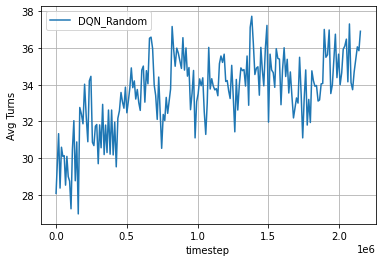

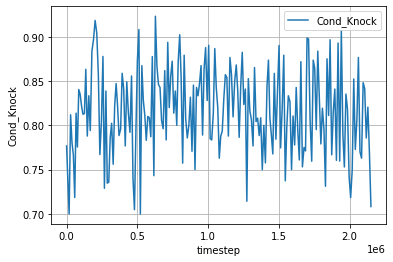

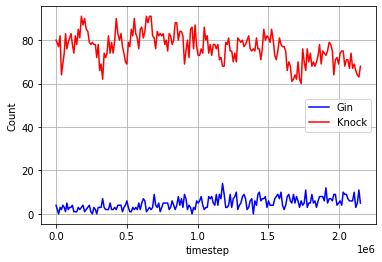

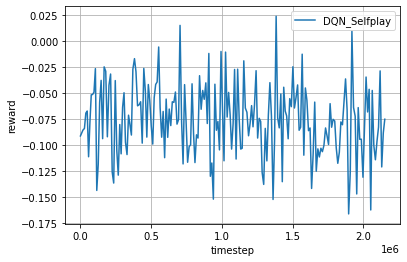

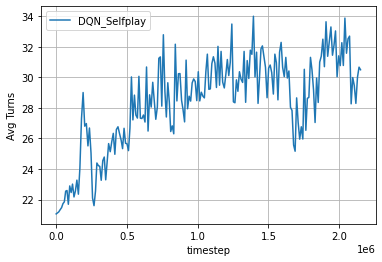

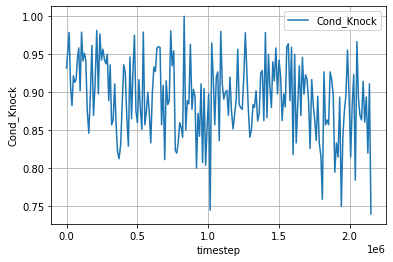

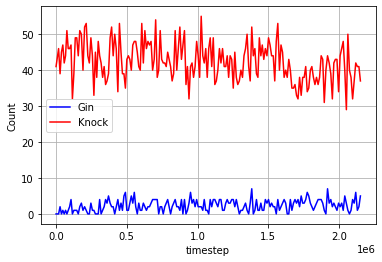

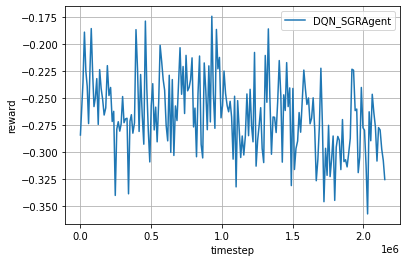

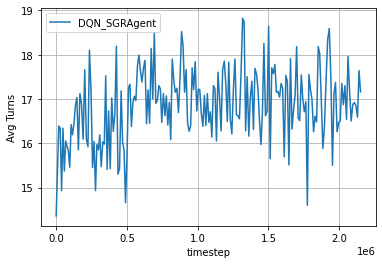

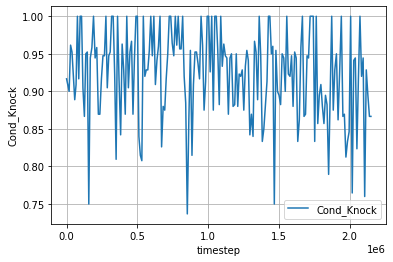

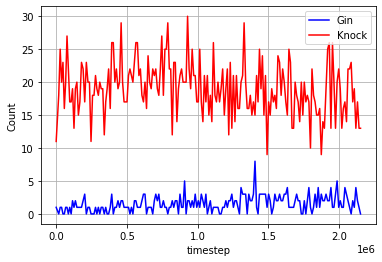

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/knockLayer/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [ ]:
model_name = 'models/dqn/knockLayer/{}/model_posttrain.pth'.format(dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 4, 'Knock': 73, 'Other': 23, 'Knock_Possible': 89, 'Avg Turns': 37.23}


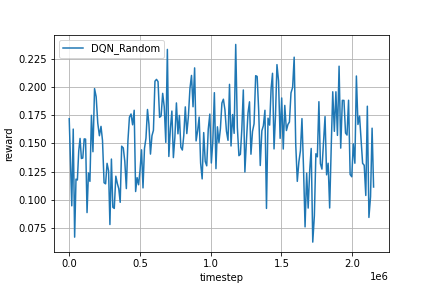

In [ ]:
Image(log_dir + '/rand_fig.png')

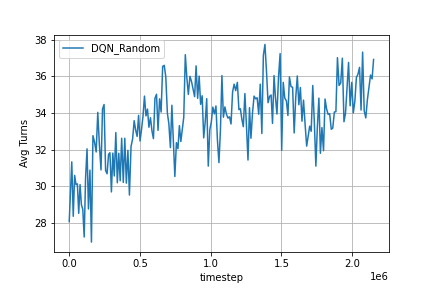

In [ ]:
Image(log_dir + '/rand_fig2.png')

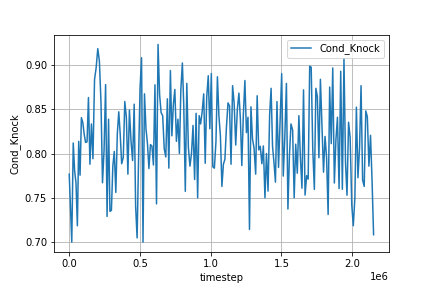

In [ ]:
Image(log_dir + '/rand_fig3.png')

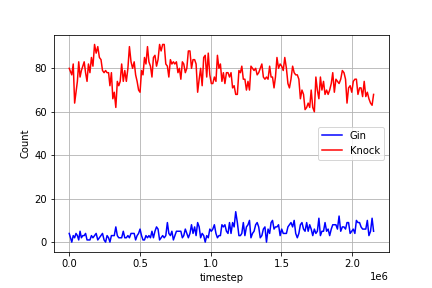

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 3, 'Knock': 38, 'Other': 59, 'Knock_Possible': 43, 'Avg Turns': 29.36}


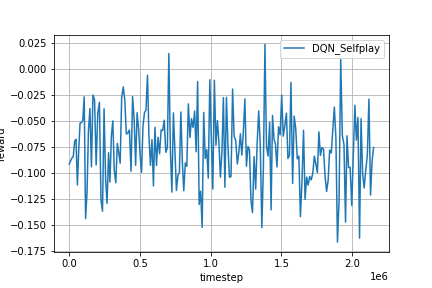

In [ ]:
Image(log_dir + '/self_fig.png')

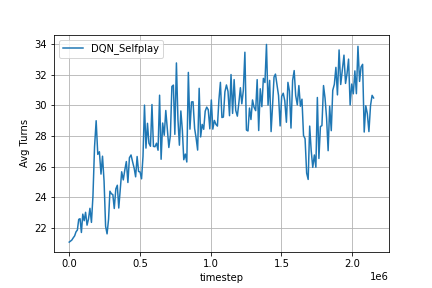

In [ ]:
Image(log_dir + '/self_fig2.png')

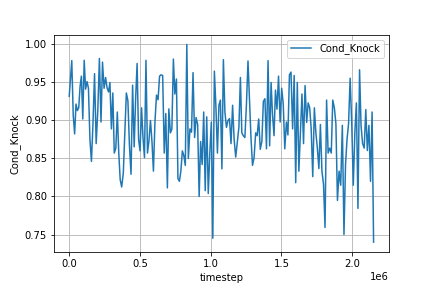

In [ ]:
Image(log_dir + '/self_fig3.png')

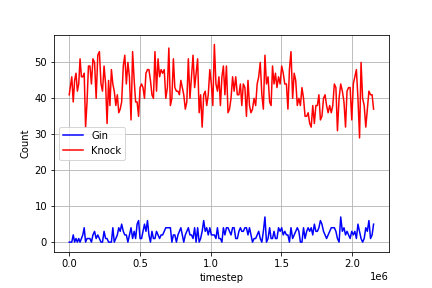

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 8, 'Other': 90, 'Knock_Possible': 11, 'Avg Turns': 18.42}


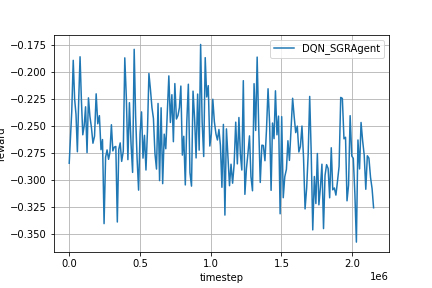

In [ ]:
Image(log_dir + '/sgr_fig.png')

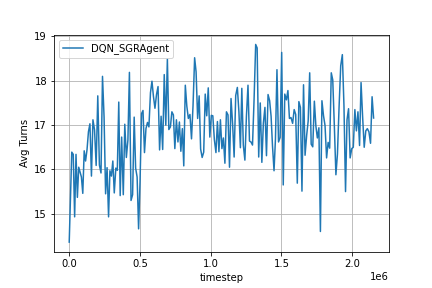

In [ ]:
Image(log_dir + '/sgr_fig2.png')

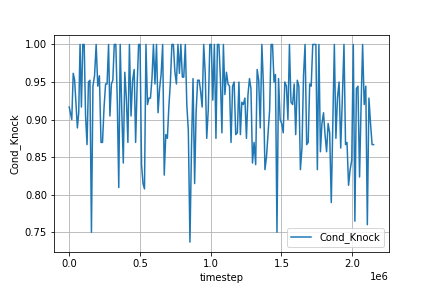

In [ ]:
Image(log_dir + '/sgr_fig3.png')

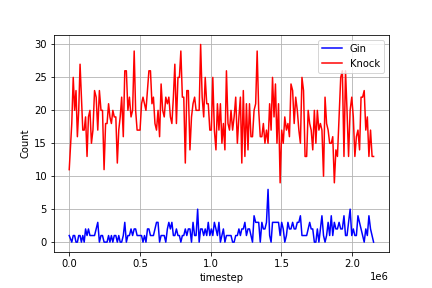

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## Artificially increased Knock Probabilities (0.0002)

### Parameters

In [4]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'knock_point0002'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# freeze_layers, copy top layer weights
freeze_layers = True
copy_top = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 0.0002

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [5]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/knockLayer/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=mlp_layers,
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm,
                knock_layer=knock_layer)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [6]:
checkpoint = torch.load(model_name, map_location=device)

# load DQN pretrained weights using built in load function
if isDQN:
    agent.load(checkpoint)
    agent2.load(checkpoint)
else:
    model_dict = checkpoint.state_dict()
    # Generate pretrained dictionary of weights/biases
    pretrained_dict = {}

    # check if there is batch norm layer
    if batch_norm:
        b_layer = 1 
        pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
        pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
        pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
        pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
        pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
    else:
        b_layer = 0

    for i in range(len(mlp_layers)):
        pretrained_dict['fc_layers.{}.weight'.format(2*i+1+b_layer)] = model_dict['l{}.weight'.format(i+1)]
        pretrained_dict['fc_layers.{}.bias'.format(2*i+1+b_layer)] = model_dict['l{}.bias'.format(i+1)]
    
    # check if copy top layer weights
    if copy_top:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.eye(110), device=device)
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = torch.tensor(np.zeros(110), device=device)
    else:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].weight
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer)] = agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer].bias
    
    # check if extra layer for knocking
    if knock_layer:
        pretrained_dict['fc_layers.{}.weight'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(np.eye(110), device=device)
        knock_probs = np.ones(110)*knock_val
        knock_probs[0:58] = 0
        pretrained_dict['fc_layers.{}.bias'.format(2*(i+1)+1+b_layer+2)] = torch.tensor(knock_probs, device=device)
    
    # load pretrained weights
    agent.q_estimator.qnet.load_state_dict(pretrained_dict)
    agent.target_estimator.qnet.load_state_dict(pretrained_dict)

In [7]:
# check if freeze layers (DO NOT FREEZE TOP LAYER)
if freeze_layers:
    for i in range(len(mlp_layers)):
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*i+1+b_layer].bias.requires_grad = False
    # check if extra layer for knocking
    if knock_layer:
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.q_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].weight.requires_grad = False
        agent.target_estimator.qnet.fc_layers[2*(i+1)+1+b_layer+2].bias.requires_grad = False

### Train

#### Training Loop

Streaming output truncated to the last 5000 lines.

SGRAgent:

----------------------------------------
  timestep     |  487723
  reward       |  -0.3096000000000002
  Avg Turns    |  16.89
  Cond_Knock   |  0.6875
  Gin: 1 | Knock: 11 | Other: 88
----------------------------------------
INFO - Agent dqn, step 249800, rl-loss: 0.008860153146088123
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  499117
  reward       |  0.1012
  Avg Turns    |  33.31
  Cond_Knock   |  0.5982905982905983
  Gin: 3 | Knock: 70 | Other: 27
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  499117
  reward       |  -0.09340000000000001
  Avg Turns    |  26.69
  Cond_Knock   |  0.7142857142857143
  Gin: 1 | Knock: 40 | Other: 59
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  499117
  reward    

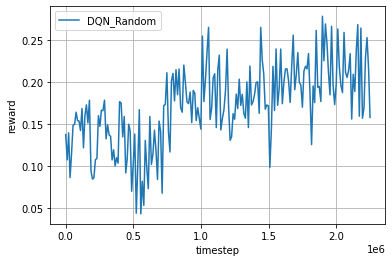

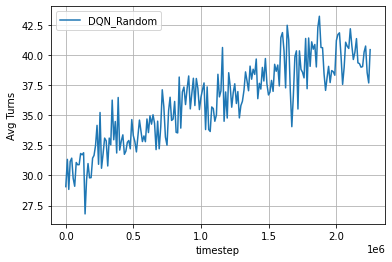

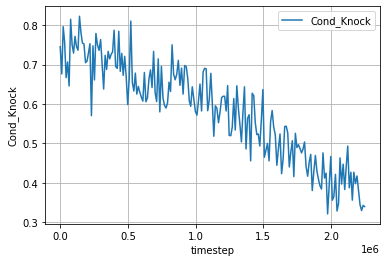

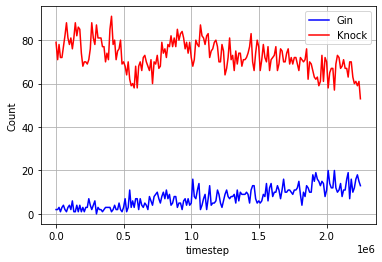

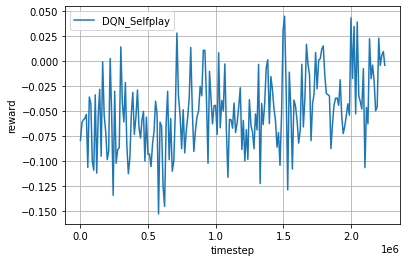

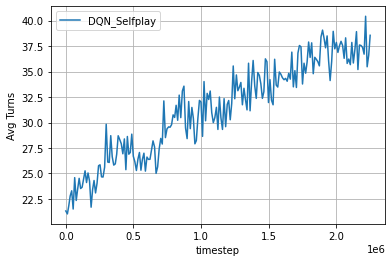

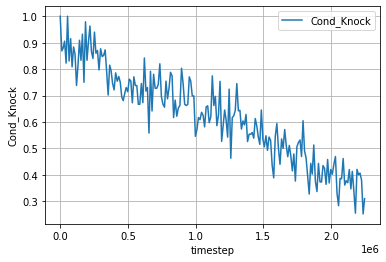

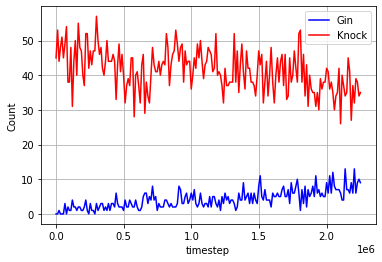

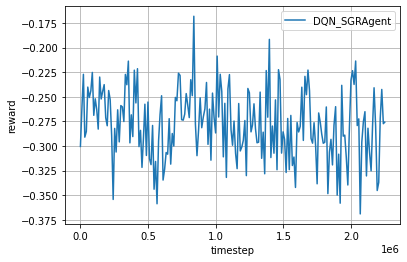

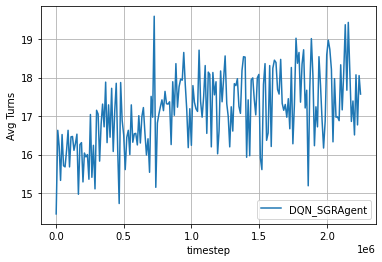

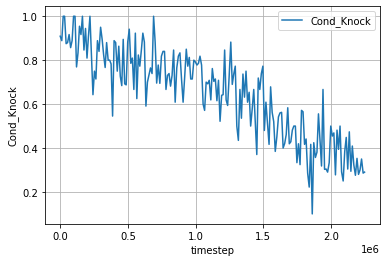

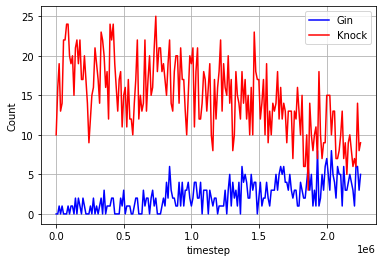

In [8]:
# Save model prior to training
save_dir = 'models/dqn/knockLayer/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [9]:
model_name = 'models/dqn/knockLayer/{}/model_posttrain.pth'.format(dqn_model_name)

In [10]:
checkpoint = torch.load(model_name, map_location=device)

In [12]:
agent.load(checkpoint)

###### Random

In [13]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 21, 'Knock': 48, 'Other': 31, 'Knock_Possible': 167, 'Avg Turns': 42.25}


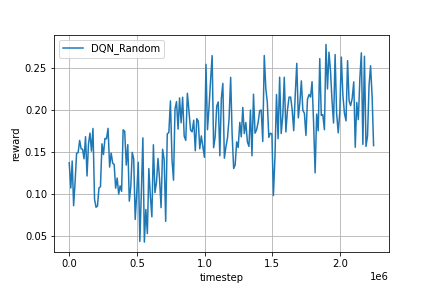

In [14]:
Image(log_dir + '/rand_fig.png')

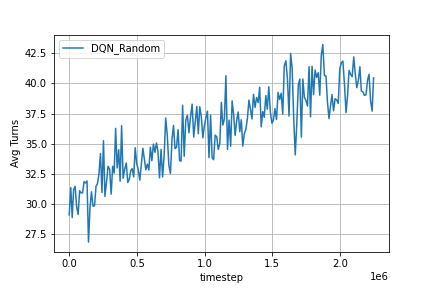

In [15]:
Image(log_dir + '/rand_fig2.png')

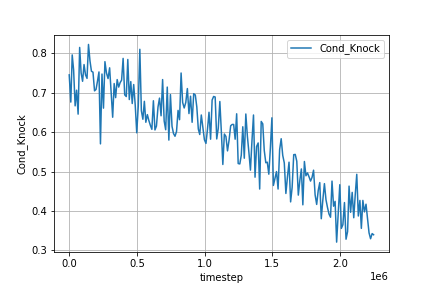

In [16]:
Image(log_dir + '/rand_fig3.png')

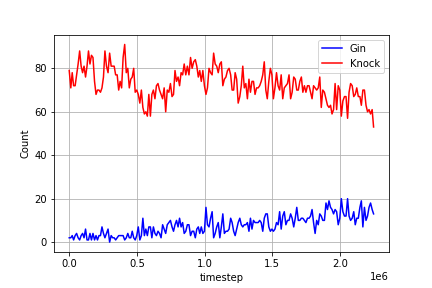

In [17]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [18]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 6, 'Knock': 32, 'Other': 62, 'Knock_Possible': 93, 'Avg Turns': 38.48}


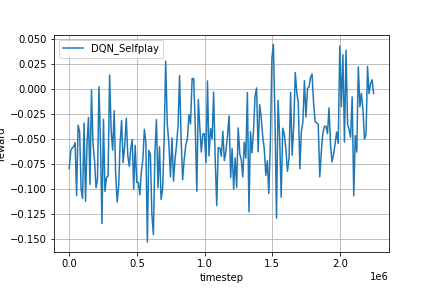

In [19]:
Image(log_dir + '/self_fig.png')

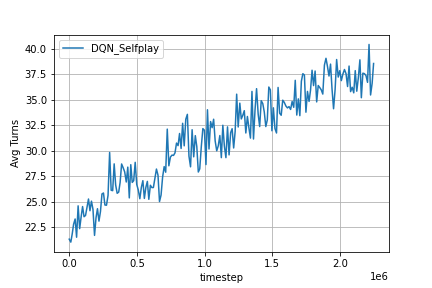

In [20]:
Image(log_dir + '/self_fig2.png')

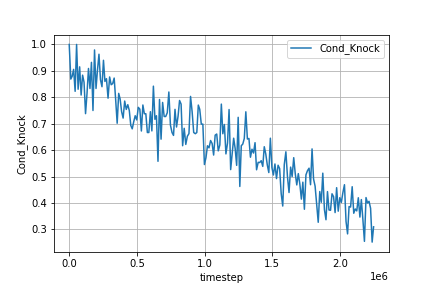

In [21]:
Image(log_dir + '/self_fig3.png')

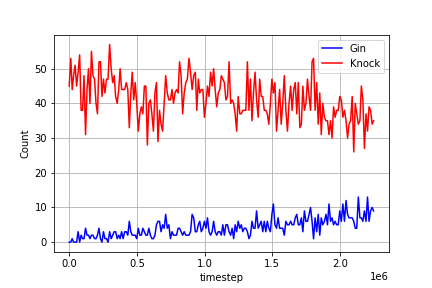

In [22]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [23]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 7, 'Other': 91, 'Knock_Possible': 25, 'Avg Turns': 18.68}


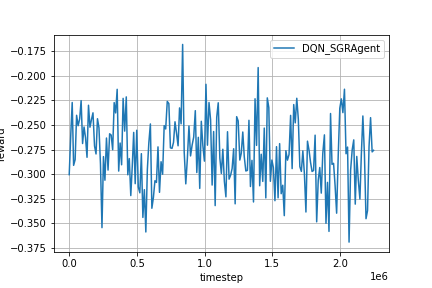

In [24]:
Image(log_dir + '/sgr_fig.png')

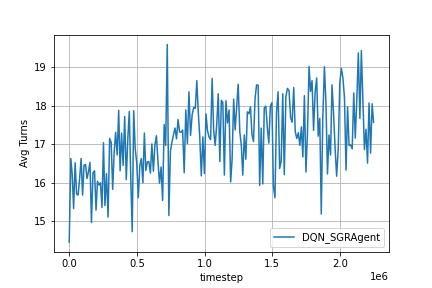

In [25]:
Image(log_dir + '/sgr_fig2.png')

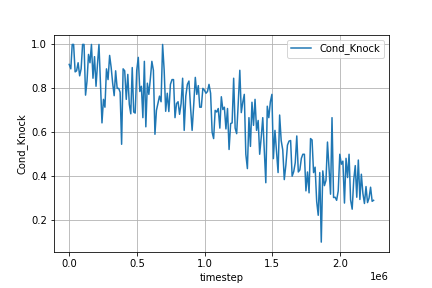

In [26]:
Image(log_dir + '/sgr_fig3.png')

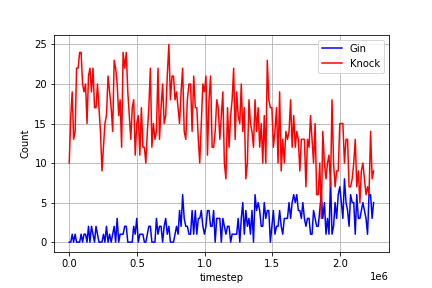

In [27]:
Image(log_dir + '/sgr_fig4.png')

# Misc

In [ ]:
model_name = 'models/dqn/iterate2/0_random/model_rand.pth'

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

In [ ]:
from rlcard.utils.logger import plot, plot_condknock,plot_actions
import os

# env_name = 'rand_'
# env_name = 'self_'
env_name = 'sgr_'
# algorithm = 'DQN_Random'
# algorithm = 'DQN_Selfplay'
algorithm = 'DQN_SGRAgent'
csv_path = os.path.join(log_dir, env_name + 'performance.csv') 
fig_path = os.path.join(log_dir, env_name + 'fig.png')
fig_path2 = os.path.join(log_dir, env_name + 'fig2.png')
fig_path3 = os.path.join(log_dir, env_name + 'fig3.png')
fig_path4 = os.path.join(log_dir, env_name + 'fig4.png')

plot(csv_path, fig_path, algorithm, ylabel='reward')
plot(csv_path, fig_path2, algorithm, ylabel='Avg Turns')
plot_condknock(csv_path, fig_path3)
plot_actions(csv_path, fig_path4)